# Expansion, verification and calibration of Edenhofer 23 maps

This notebook accompains paper (insert reference) describing the NH-3D-tool. The basic idea behind it is to use high-resolution optical extintion maps published recently by [Edenhofer et al, 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230801295E/abstract) and covering distances up to ~2 kpc and extend those using a combination of infrared dust emission and radio dispersion measure-based maps. The details are described in the paper, but some useful figures and further explanations are also presented here. The notebook covers most of the steps described in the paper step by step in order to make the process reproducible. Note that some dependencies might need to be installed, plot style adjusted etc.

In [1]:
import numpy as np
import healpy as hp
import pylab as pl
import scipy.stats, scipy.interpolate, scipy.optimize
import pandas as pd
import astropy.coordinates as c
import astropy.units as u
from astroquery.vizier import Vizier
import astropy.io.fits as fits
import ultranest, corner
import matplotlib
import pickle
matplotlib.style.use('sm')

## Comparison of integrated E23 and Planck GNILC maps

Let us first read integrated versions of  [Edenhofer et al, 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230801295E/abstract) (E23) maps queried using [*dustmaps*](https://dustmaps.readthedocs.io/en/latest/) package (here stored in integrated format for convinience) and Planck GNILC maps. First read E23 map. The code to calculate it is commented out:

In [2]:
# Edenhofer 23 maps
me23 = np.load('ed23_cum.npz')['maps']*2.8/3.1 # convert to E(B-V) units using assumed R_V=3.1 and A_V/A_0=2.8 as stated in Edenhofer et al. 2023 (E23)
re23 = np.load('ed23_cum.npz')['radius']
# for some things we need also to know coordinates of the map pixels, so generate those
l, b = hp.pix2ang(256,np.arange(hp.nside2npix(256)),lonlat=True)

"""
# Here all available maps are calibrated and fused.
import astropy.io.fits as pyfits
import astropy.units as u
import astropy.coordinates
import healpy as hp
import scipy.interpolate
from dustmaps.config import config
config['data_dir'] = '/Users/doroshv/miniforge3/lib/python3.9/site-packages/dustmaps/data'
from dustmaps.edenhofer2023 import Edenhofer2023Query
import pickle
import pylab
pylab.style.use('sm')
import pandas as pd

NSIDE = 256
l,b = hp.pix2ang(NSIDE,arange(hp.nside2npix(NSIDE)),lonlat=True)


# Read Eden radial bins and maps. We don't actually use maps themselves but rather query via dustmaps later
qeden = Edenhofer2023Query(integrated=True,flavor='less_data_but_2kpc')
hdu = pyfits.open('/Users/doroshv/miniforge3/lib/python3.9/site-packages/dustmaps/data/edenhofer_2023/validation_with_less_data_but_2kpc_mean_and_std_healpix.fits')

r1 = transpose([x for x in hdu['RADIAL PIXEL BOUNDARIES'].data])[0]
mul = 1/median(r1[:-1]/diff(r1)) # geometric progression factor
rr = [0] + list(r1)
# Choice of 25 kpc is arbitrary, the aim is just to include most of the absorbing material
while rr[-1]<=25000:
    rr.append(rr[-1]+rr[-1]*mul)
rr = rr[:-1]
rr[-1]=20000
rr = array(rr)

imax = rr.searchsorted(2000)
maps_e = []
for i in range(imax):
    print(i)
    cc = astropy.coordinates.SkyCoord(l*u.deg,b*u.deg,rr[i]*u.pc,frame='galactic')
    maps_e.append(qeden.query(cc))

np.savez_compressed('ed23_cum.npz',radius=rr[2:imax-1],maps=array(maps_e[2:-1],dtype=float16))"""

"\n# Here all available maps are calibrated and fused.\nimport astropy.io.fits as pyfits\nimport astropy.units as u\nimport astropy.coordinates\nimport healpy as hp\nimport scipy.interpolate\nfrom dustmaps.config import config\nconfig['data_dir'] = '/Users/doroshv/miniforge3/lib/python3.9/site-packages/dustmaps/data'\nfrom dustmaps.edenhofer2023 import Edenhofer2023Query\nimport pickle\nimport pylab\npylab.style.use('sm')\nimport pandas as pd\n\nNSIDE = 256\nl,b = hp.pix2ang(NSIDE,arange(hp.nside2npix(NSIDE)),lonlat=True)\n\n\n# Read Eden radial bins and maps. We don't actually use maps themselves but rather query via dustmaps later\nqeden = Edenhofer2023Query(integrated=True,flavor='less_data_but_2kpc')\nhdu = pyfits.open('/Users/doroshv/miniforge3/lib/python3.9/site-packages/dustmaps/data/edenhofer_2023/validation_with_less_data_but_2kpc_mean_and_std_healpix.fits')\n\nr1 = transpose([x for x in hdu['RADIAL PIXEL BOUNDARIES'].data])[0]\nmul = 1/median(r1[:-1]/diff(r1)) # geometric pro

read also pre-computed GNILC map and its uncertainty associated with down-sampling from NSIDE=2048 to 256 (also pre-computed). Here I omit the downsampling step, but basically it is done by a) smoothing the original map queried using *dustmaps* with Gaussian kernel corresponding to NSIDE=256, and then applying *hp.ud_grade* function (smoothing improves the agreement between original and up-graded downsampled maps slightly). The uncertainty is estimated by comparing down-sampled NSIDE=256 map upsampled to 2048 again. 

In [3]:
ebv_gnilc = hp.read_map('ebv_val_hpx.fits') # queried using dusmaps module on a grid corresponding to NSIDE=2048 and then downgraded to NSIDE=256
ebv_gnilc_e = hp.read_map('ebv_err_hpx.fits') # that's the error map, i.e. difference between original GNILC and down/upgraded version

Now we can plot the two maps (i.e. GNILC and integrated Edenhofer maps). They appear to be generally similar, but also some differences are notable. That is, much lower reddening of E23 in the Galactic plane due to limited depth of the map, but also somehwat lower contrast, i.e. E23 underestimates reddening in some compact dense regions. On the other hand, GNILC also includes some extra-Galactic absorbtion component (i.e. we do see Magellanic clouds in the map).

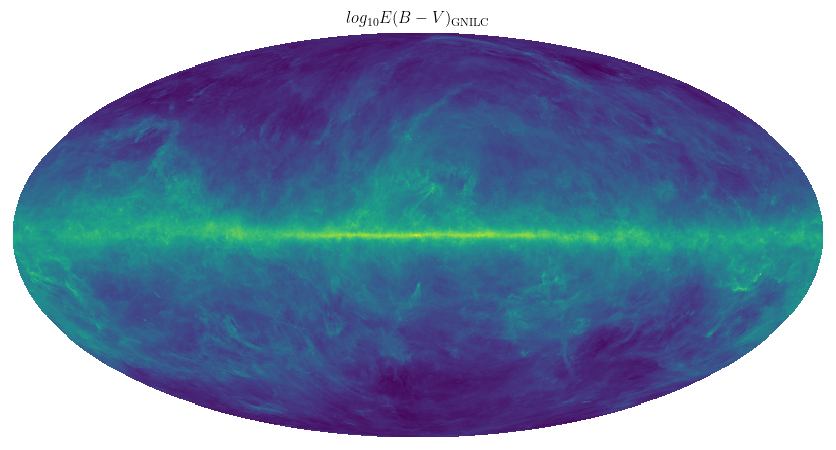

In [4]:
hp.mollview(np.log10(ebv_gnilc), title=r'$log_{10}{E(B-V)_{\rm GNILC}}$',cbar=False)
pl.savefig('gnilc256.pdf')

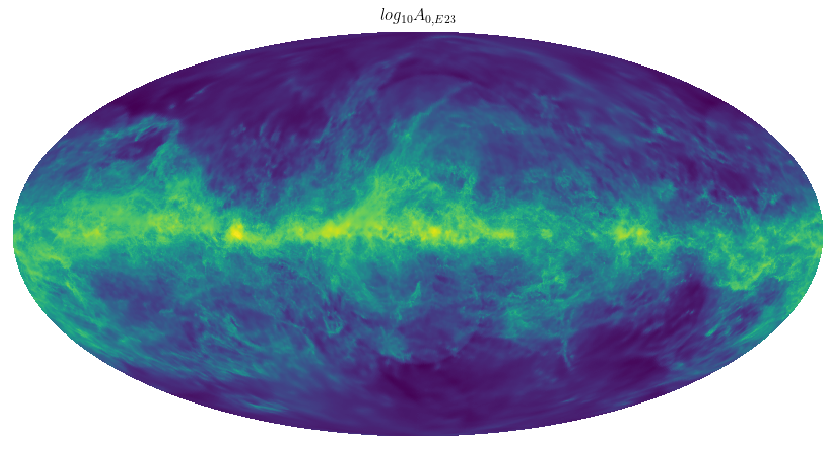

In [5]:
maxopt = me23[-1,:] #integrated optical extinction map
hp.mollview(np.log10(maxopt), title=r'$log_{10}{A_{0,E23}}$',cbar=False)
pl.savefig('e23_int_256.pdf')

As one can see, overall agreement is pretty good! Except in the Galactic plane where depth of E23 maps is insufficient to probe bulk of the absorbing material. We can  make a histogram to see where in terms of $|b|$ we start to have deviations comparable with errors we get due to downsampling of GNILC map:

Text(0, 0.5, '$\\Delta E(B-V)$')

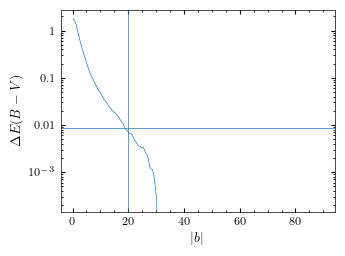

In [6]:
differences = scipy.stats.binned_statistic(np.abs(b), ebv_gnilc-maxopt, bins=np.arange(-91,91,0.5), statistic='median')
pl.plot((differences[1][1:]+differences[1][:-1])/2., differences[0])
pl.axhline(np.median(ebv_gnilc_e))
pl.semilogy()
pl.axvline(20)
pl.xlabel('$|b|$')
pl.ylabel('$\Delta E(B-V)$')

i.e. maps match fairly well for $|b|\gtrsim20^\circ$. But also plot one vs another:

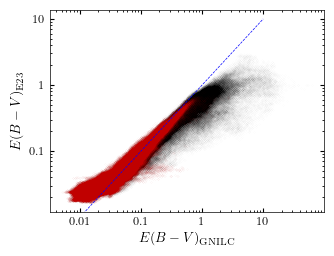

In [7]:
pl.loglog(ebv_gnilc,maxopt,'k.',ms=0.1,alpha=0.1,rasterized=True)
pl.loglog(ebv_gnilc[abs(b)>20],maxopt[abs(b)>20],'r.',ms=0.1,alpha=0.2,rasterized=True)
pl.plot(np.linspace(0,10),np.linspace(0,10),'b--',label=r'$R_V=3.1$')
pl.xlabel(r'$E(B-V)_{\rm GNILC}$')
pl.ylabel(r'$E(B-V)_{\rm E23}$')
# pl.ylabel(r'$A_{V,\rm E23}$')
# pl.legend(frameon=False)
pl.savefig('ebv_gnilc_uncor_e23.pdf')

Two things can be noted: while the correlation is good, E23 strongly underpredicts reddening for denser areas (Galactic plane), and overall is not perfect. Furthermore, on average Planck slightly underestimates optical reddening at low values. The difference is comparable with median error of the map itself (i.e. values reported by map + uncertainties due to downsampling), but it's there. We can estimate this constant along with effective $R_V$ and the uncertainty of the final map. Use bayesian inference package [*ultranest*](https://johannesbuchner.github.io/UltraNest/index.html) to do that. In particular, consider uncertainty of the final map to be a composition of additive and relative uncertainties considered as free parameters. 

In [8]:
# only consider low-density regions for fitting - we know that in the Galactic plane the two maps should not match
mask_low_redd = ebv_gnilc<0.3
x,y = ebv_gnilc[mask_low_redd],maxopt[mask_low_redd]
# gnilc_errpr
gne = ebv_gnilc_e[mask_low_redd]

parameters = ['add_err', 'rel_err','Rv_correction', 'add_constant'] #Note that Rv~1 as we alredy multiplied E23 by 2.8/3.1


def prior_transform_e23xgnilc(cube):
    params = cube.copy()
    lo = 0
    hi = 0.5
    params[0] = cube[0] * (hi - lo) + lo
    lo = 0
    hi = 1.5
    params[1] = cube[1] * (hi - lo) + lo
    lo = 0.5
    hi = 1.5
    params[2] = cube[2] * (hi - lo) + lo
    lo = 0.0
    hi = 0.1
    params[3] = cube[3] * (hi - lo) + lo
    return params

def log_likelihood_e23xgnilc(params):
    # unpack the current parameters:
    # slope, offset, scatter = params
    add_err, rel_err, Rv_correction, add_constant = params
    ebv_expected = (x + add_constant) * Rv_correction
    # add GNILC downsampling error in quadrature to the parmetrized error between the maps in form of additive and relative errors
    probs_ebv = scipy.stats.norm(ebv_expected,np.sqrt((rel_err*ebv_expected)**2+add_err**2+gne**2)).pdf(y)
    loglike = np.log(probs_ebv + 1e-100).sum()
    return loglike

sampler_e23xgnilc = ultranest.ReactiveNestedSampler(parameters, log_likelihood_e23xgnilc, prior_transform_e23xgnilc)

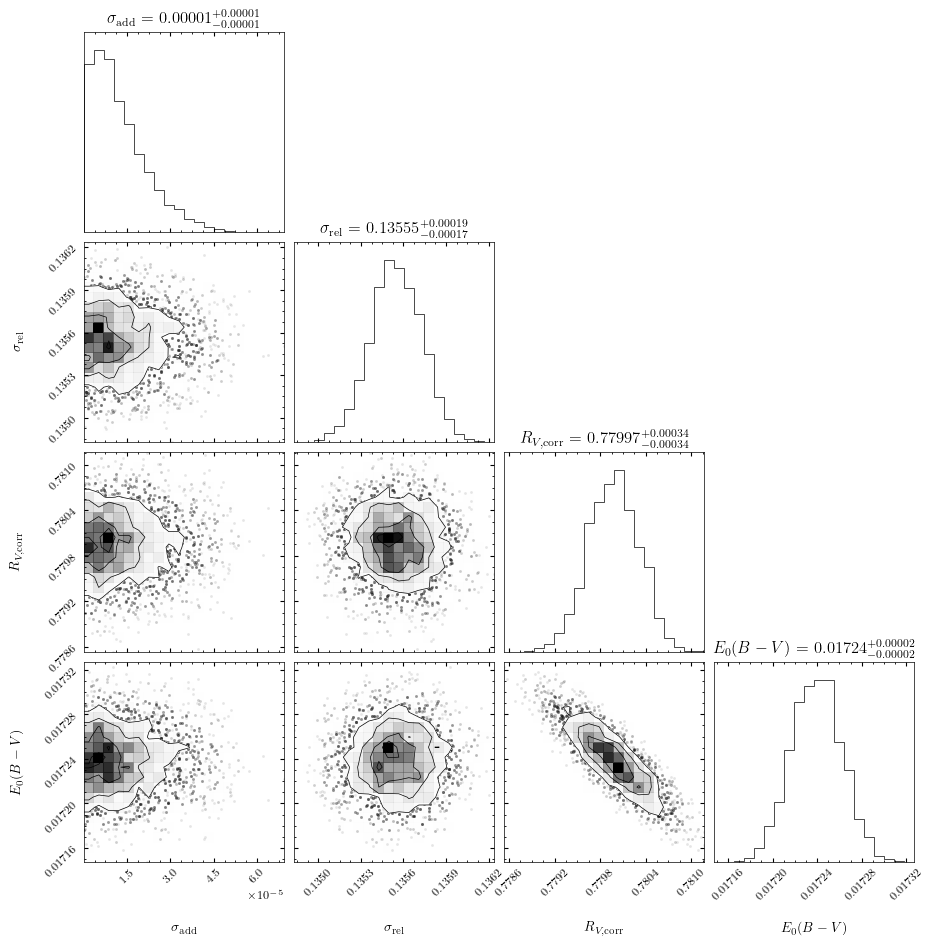

In [9]:
result_e23xgnilc = pickle.load(open('ultranest_result_e23xgnilc.pkl','rb'))
junk = corner.corner(result_e23xgnilc['samples'],show_titles=True,labels=[r'$\sigma_{\rm add}$',r'$\sigma_{\rm rel}$',r'$R_{V, \rm{corr}}$', '$E_0(B-V)$'],title_fmt='.5f')
pl.savefig('corner_e23ebvxgnilcebv.pdf')

In [10]:
#result_e23xgnilc = sampler_e23xgnilc.run() #run (or not run) the sampler
#pickle.dump(result_e23xgnilc,open('ultranest_result_e23xgnilc.pkl','wb')) # save (or load) the results
result_e23xgnilc = pickle.load(open('ultranest_result_e23xgnilc.pkl','rb'))

That impllies that GNILC, as suggested by number of authors (see i.e. [Schröder et al 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.503.5351S/abstract)  and references therein) does indeed need some correction factor of ~0.8 plus a small offset of ~0.02 mag (not mentioned by these authors) to match optical extinction reported by E23. Note that presence of this extra additive constant is actually not surprising that *Planck* does not see dust in very weakly absorbing regions, after all, its sensitivity is limited, so one does not expect it to see all the dust/gas (which stills absorbes light). This constant will, however, be important later on when discussing correlation between extinction and absorbtion.

Now we can combine both maps to use corrected GNILC map in high density areas (Galactic plane) and E23 map otherwise. The main motivation for such combination (rather than simply using GNILC for infinity) is to remove contribution of Magellanic clouds and a couple of other dense, likely extragalactic, regions at high Galactic lattitudes (i.e. I assume that E23 is more reliable here). We also want to stay consistent for some small-scale structures evident in E23 map but having lower extintion than what's implied by Planck. That might be not ideal solution, but the other option is to correct E23 map itself, which can be done by number of ways and the best way would be to re-generate the map with slightly different priors or more data (which is beyond the scope of current work)

Note that Magellanic clouds disappear in the fused map due to the adopted cut in difference of 1 magnitude (for these densitites values of E23 map are used and this does not contain extragalacitc content). Note also that the final map smoothly transitions from E23 to GNILC as mask is not binary but rather smoothed with NSIDE=128 (could go lower, but this is sufficient). Also calculate the uncertainty of the final map using results obtained above.

First let us plot the corrected GNILC map (i.e. multiplied by 0.8 with added additive constant) vs optical reddening for verification:

In [11]:
add_err, rel_err,Rv_correction, add_constant = result_e23xgnilc['posterior']['mean']

ebv_gnilc_cor = (ebv_gnilc+add_constant)*Rv_correction
ebv_gnilc_cor_e = np.sqrt(add_err**2+(ebv_gnilc_cor*rel_err)**2+ebv_gnilc_e**2)

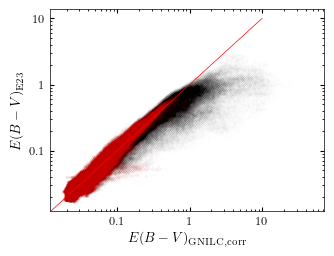

In [12]:
pl.loglog(ebv_gnilc_cor,maxopt,'k.',ms=0.1,alpha=0.1,rasterized=True)
pl.loglog(ebv_gnilc_cor[abs(b)>20],maxopt[abs(b)>20],'r.',ms=0.1,alpha=0.2,rasterized=True)
pl.plot(np.linspace(0,10),np.linspace(0,10),'r-')
pl.xlabel(r'$E(B-V)_{\rm GNILC, corr}$')
pl.ylabel(r'$E(B-V)_{\rm E23}$')
pl.savefig('ebv_gnilc_cor_e23.pdf')

The differences start to appear now at reddenings beyond 1 magnitude, which is approximately the depth actually covered by E23 map, so overall agreement is at expected level and we proceed to fusion of the maps to include the Galactic plane as described above.

In [13]:
mask_e23 = (ebv_gnilc_cor+3*result_e23xgnilc['posterior']['mean'][-1]<=maxopt)+(ebv_gnilc_cor<0.3) # areas where E23 values will be used

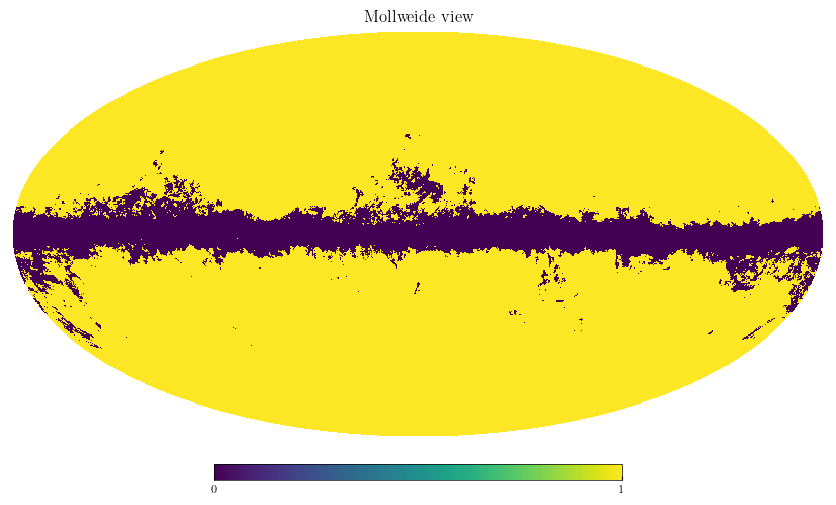

In [14]:
hp.mollview(mask_e23)

In [15]:
mask_e23[mask_e23-hp.smoothing(mask_e23,hp.nside2resol(32))<-0.5]=1

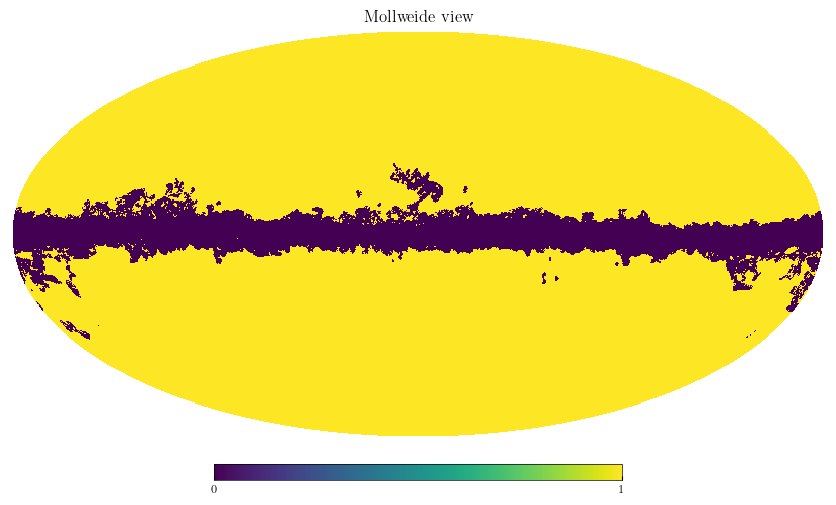

In [16]:
hp.mollview(mask_e23)

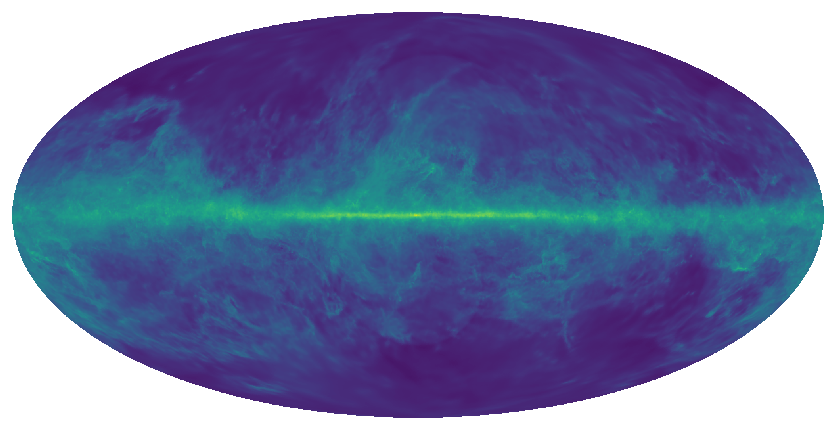

In [17]:
mask_e23 = hp.smoothing(mask_e23,hp.nside2resol(32))
# clip to [0-1] as due to smoothing it can go out
mask_e23[mask_e23<=0]=0.0
mask_e23[mask_e23>=1]=1.0
ebv_fin = maxopt*mask_e23+ebv_gnilc_cor*(1.0-mask_e23)
ebv_fin[ebv_fin<=maxopt]=maxopt[ebv_fin<=maxopt] # ensure that map always exceeds E23 values
ebv_fin+=1e-5
# hp.mollview(np.log10(ebv_fin),title=r'$log_{10}{E(B-V)_{fused}}$',cbar=False)
hp.mollview(np.log10(ebv_fin),title='',cbar=False,min=-2,max=2,xsize=2048)
# hp.mollview((mask_e23>=0.01)*(mask_e23<=0.99), alpha=(mask_e23>=0.05)*(mask_e23<=0.95)*0.3, fig=pl.gcf(),reuse_axes=True,cbar=False,cmap=pl.cm.binary,title='')
pl.savefig('integrated_fused256.pdf')

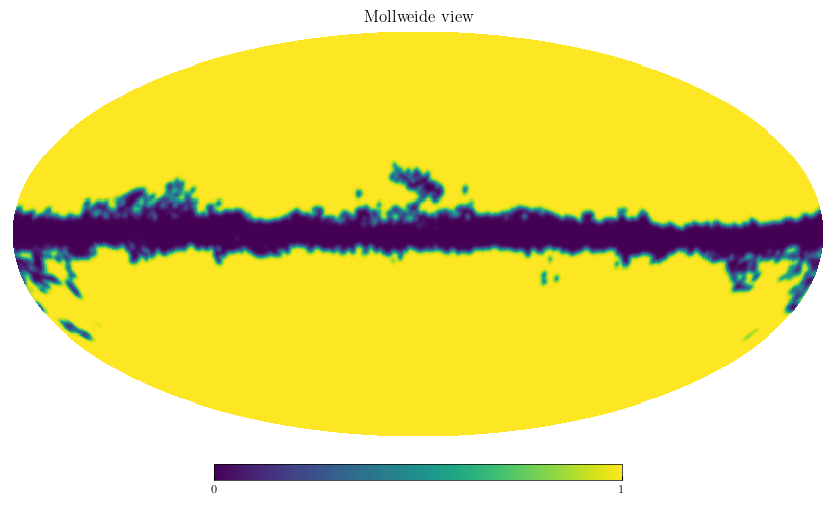

In [18]:
hp.mollview(mask_e23)

We cal also ilustrate difference between corrected GNILC and E23 maps, and areas where GNILC values are preferred (within red contours):

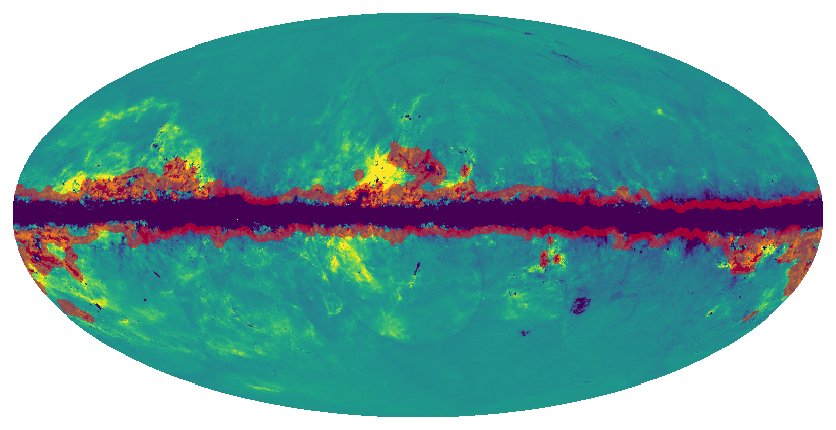

In [19]:
hp.mollview(maxopt-ebv_gnilc_cor,min=-0.1,max=0.1,cbar=False)
hp.mollview((mask_e23>=0.01)*(mask_e23<=0.99), alpha=(mask_e23>=0.05)*(mask_e23<=0.95)*0.5, fig=pl.gcf(),reuse_axes=True,cbar=False,cmap=pl.cm.hsv,title='',xsize=2048)
pl.savefig('e23mgnilc_mask.pdf')

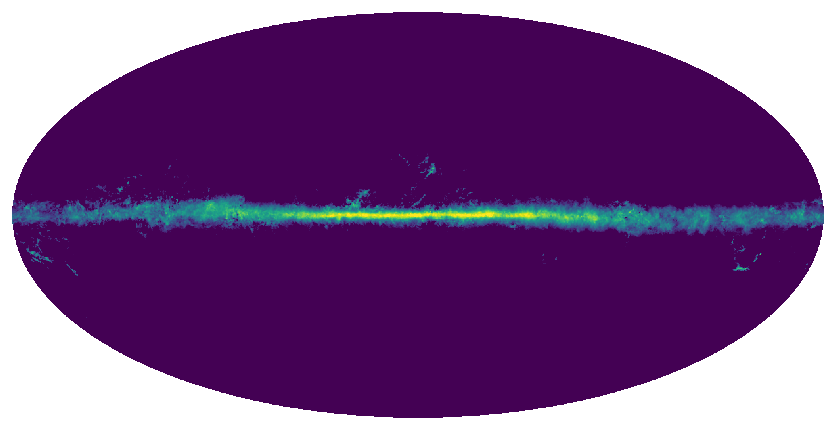

In [20]:
hp.mollview(np.log10(ebv_fin-maxopt),title='',min=-1,max=1,xsize=2048,cbar=False)
pl.savefig('efinme23.pdf')

We can also plot direct comparison of the corrected \textit{GNILC} map with fused map presented above, i.e.:

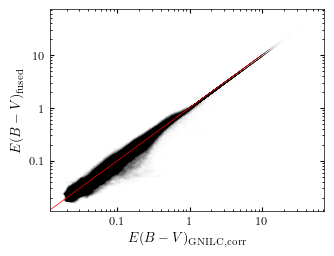

In [21]:
pl.loglog(ebv_gnilc_cor,ebv_fin,'k.',ms=0.1,alpha=0.1,rasterized=True)
# pl.loglog(ebv_gnilc_cor[abs(b)>20],maxopt[abs(b)>20],'r.',ms=0.1,alpha=0.2,rasterized=True)
pl.plot(np.linspace(0,10),np.linspace(0,10),'r-')
pl.xlabel(r'$E(B-V)_{\rm GNILC, corr}$')
pl.ylabel(r'$E(B-V)_{\rm fused}$')
pl.savefig('ebv_gnilc_cor_fused.pdf')

Now we can start extending the 3D map using 2D reddening at infinity from the combined map shown above, and 3D information from YMW16 dispersion-measure based map. To do this, first read pre-computed integrated maps. Here I use pre-computed version (using the code in the commented cell):

In [22]:
junk = """
# Here integrated YMW16 DM map is produced and saved
import astropy.io.fits as pyfits
import astropy.units as u
import astropy.coordinates
import healpy as hp
import scipy.interpolate
from dustmaps.config import config
config['data_dir'] = '/Users/doroshv/miniforge3/lib/python3.9/site-packages/dustmaps/data'
from dustmaps.edenhofer2023 import Edenhofer2023Query
import pickle
import pylab
pylab.style.use('sm')
import pandas as pd
import pygedm

# Read Eden MAP
hdu = pyfits.open('/Users/doroshv/miniforge3/lib/python3.9/site-packages/dustmaps/data/edenhofer_2023/validation_with_less_data_but_2kpc_mean_and_std_healpix.fits')
# other maps are nested, this one is not nested, so pixel numbers are different
eden_hpx = hp.reorder(hdu[1].data,inp='nest',out='ring')
eden_hpx0 = hp.reorder(hdu[-2].data,inp='nest',out='ring')
# we also need to add extinction between 0 and 68pc 
eden_hpx = vstack((eden_hpx0,eden_hpx))
# eden_hpx*=2.8 # to convert to Av (see i.e. p6 in Eden's paper)

r1 = transpose([x for x in hdu['RADIAL PIXEL BOUNDARIES'].data])[0]
mul = 1/median(r1[:-1]/diff(r1)) # geometric progression factor
rr = [0] + list(r1)
# Choice of 20 kpc is arbitrary, it seems that HI maps are ~valid up to 20kpc galactocentric distance from Fig 9 in https://arxiv.org/pdf/2202.02341.pdf
while rr[-1]<=25000:
    rr.append(rr[-1]+rr[-1]*mul)
rr = rr[:-1]
rr[-1]=25000
rr = array(rr)


ymw = lambda r: pygedm.generate_healpix_dm_map(r,nside=256, method='ymw16')
ymw16 = zeros((len(rr[1038:]),hp.nside2npix(256)))
for i in range(len(rr[1038:])):
    print(i)
    ymw16[i] = ymw(rr[i+1038])
np.savez_compressed('ymw16_cum_ext.npz',radius=rr[1:],maps=ymw16.astype(float16))
"""

In [23]:
# And YMW16 DM maps
ymw16 = np.load('ymw16_cum.npz')['maps'][1:]
rymw16 = np.load('ymw16_cum.npz')['radius'][1:]

ymw16ext = np.load('ymw16_cum_ext.npz')['maps'][1:]
rymw16 = np.load('ymw16_cum_ext.npz')['radius'][1:]
ymw16 = np.vstack((ymw16,ymw16ext[1:]))

Before using the DM data it would be great, however, to check whether the YMW map is actually similar to extinction maps. To do that, we subtract E23 integrated up to 2\,kpc from the final fused reddening map, and subtract YMW16 integrated up to 2 kpc from total integrated map. This allows to compare both in region where most of the fine structures captured by E23 and abscent in YMW16 by definition become irrelevant, i.e. mostly Galactic plane. Note that it only makes sense to do it within Galactic plane only anyway as that's where we want to use DM maps for extension (away from the Galactic plane the agreement between E23 and GNILC maps is already good as we demonstrated above).

Pearson correlation coefficient between excess DM and excess extintion is: 0.83


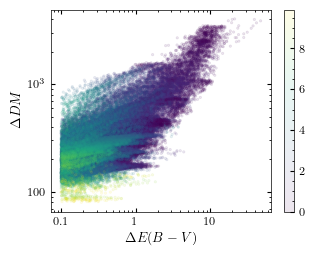

In [24]:
ymw0 = ymw16[rymw16.searchsorted(re23[-1]),:]
dDM = ymw16[-1,:]-ymw0
dDE = ebv_fin - maxopt
# to mask by coordinates we need to know those for each pixel
l,b = hp.pix2ang(256,np.arange(hp.nside2npix(256)),lonlat=True)
m = (ebv_fin>0.1)*(abs(b)<=10)*(dDE>0.1)
pl.scatter(dDE[m],dDM[m],c=abs(b[m]),alpha=0.1,s=3)
pl.colorbar()
pl.loglog()
pl.xlabel('$\Delta E(B-V)$')
pl.ylabel('$\Delta DM$')
print("Pearson correlation coefficient between excess DM and excess extintion is: %.2f"%np.corrcoef(dDE[m],dDM[m])[0][1])

Note that the correlation is actually quite good, especially considering that YMW16 model is only a rough model. The correlation only improves as we go to lower Galactic lattitudes (i.e. look at integrated emisison in the Galactic plane). We can also calculate conversion coefficient between DM and optical reddening (can be useful in the future):

Pearson correlation coefficient between excess DM and excess extintion is: 0.86
$DM = E(B-V) * (331.12 +/- 203.10$)DM


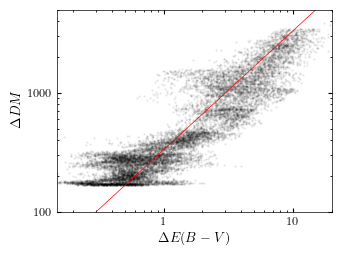

In [25]:
m = (ebv_fin>0.1)*(abs(b)<=1)*(dDE>0.1)
dm2ebv = np.median(dDM[m]/dDE[m])
dm2ebvs = np.std(dDM[m]/dDE[m])


pl.plot(dDE[m],dDM[m],'k.',ms=1,alpha=0.1)
pl.loglog()
pl.xlabel('$\Delta E(B-V)$')
pl.ylabel('$\Delta DM$')

print("Pearson correlation coefficient between excess DM and excess extintion is: %.2f"%np.corrcoef(dDE[m],dDM[m])[0][1])
print('$DM = E(B-V) * (%.2f +/- %.2f$)DM'%(dm2ebv,dm2ebvs))
pl.plot([0.1,20],np.array([0.1,20])*dm2ebv,'r-')
pl.ylim(100,5000)
pl.xlim(0.15,20)
pl.yticks([100,1000],['100','1000'])
pl.savefig('debv_ddm.pdf')

This gives us justification and confidence to use at least 3D information from YMW16 for parts of the Galaxy we can not observe otherwise. The absolute differences in reddening estimated from scaling of YMW16 DM would, however, be quite large. The idea is thus to use dust reddening as proxy to distribution of absorbtion over the sky (integrated over line of sight), and DM data only to map dust distribution along line of sight beyond 2 kpc. That is, we take the missing reddening (i.e. that appearing beyond 2 kpc) from comparison of (corrected) GNILC and E23 maps, and distribute that according to expectations from YMW23. To do that, we need to subtract integrated E23 cube from dust maps and YMW16 integrated up to 2 kpc from that integrated to infinity and divide one by another, i.e.:

In [26]:
imax_e23 = len(re23)-1 # starts with zero, radius grid is same for both maps in overlapping range
dDEBV = ebv_fin - me23[imax_e23,:]
dDM = ymw16[-1,:] - ymw16[imax_e23,:]
dm2ebv_coeff = dDEBV/dDM

This can now be used to augument E23/GNILC maps. First let us create final cube reddening cube filled with E23 values up to 2kpc and scaled DM values after that such that total integrated cube adds up to (corrected) dust map:

In [27]:
final_cube = np.zeros_like(ymw16)

Fill inner 2kpc with E23 values (already converted to reddening units assuming $R_V$=3.1 above)

In [28]:
final_cube[:imax_e23+1,:] = me23

Finally fill the rest with scaled DM values

In [29]:
final_cube[imax_e23+1:,:] = final_cube[imax_e23,:] + (ymw16[imax_e23+1:,:] - ymw16[imax_e23,:])*dm2ebv_coeff

And of course, view the integrated version of what we got (=GNILC by definition)

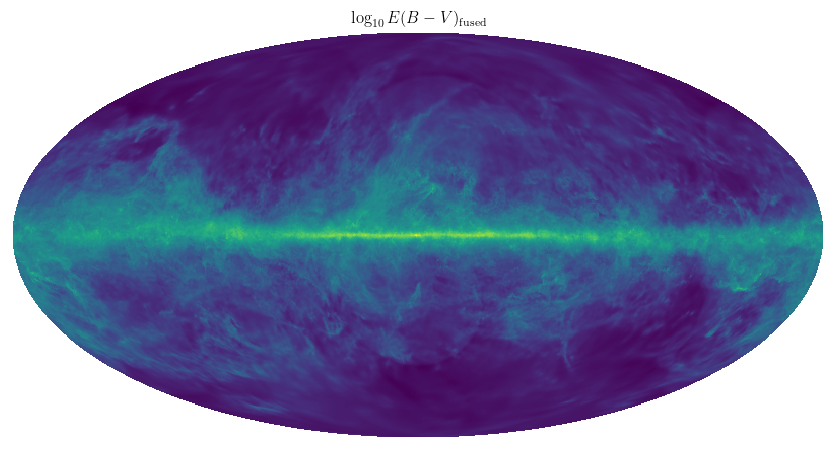

In [30]:
hp.mollview(np.log10(final_cube[-1,:]),title=r'$\log_{10}{E(B-V)_{\rm fused}}$',cbar=False)
pl.savefig('ebv_fused.pdf')

As one can see, it matches (by definition) the fused E23/GNILC map shown above, but now this is actually a data cube which contains spatial information for each sky pixel. Let us save it for future use to avoid re-calculations. Accuracy of single-precision floats is more than adequate given our uncertainties

In [31]:
np.savez_compressed('e23_x_ymw16.npz',maps = final_cube.astype(np.float16), radius=rymw16)

## Calibration of the fused reddening map using external optical extinction data

The cube presented above is in E23 units multiplied by factor 2.8/3.1, i.e. should be reddening assuming standard $R_V$. As discussed by E23, however, this conversion is not fully correct as their maps are, in fact, monochromatic extinction rather than reddening maps. We can attempt to calibrate this cube to give reddening/extinction using some external data. This will also help to verify the maps.
Ideally, we would like to use independent extintion measurements not used by E23. First let us look in different extinction/reddening estimates. In particular, two papers [Yu et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJS..264...41Y/abstract) (based on RAVE data, covers most of the sky) and [Dékány et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...883...58D/abstract) (cepheids studies, mostly Galactic plane and mostly stars far away from us). Both tables can be queried from Vizier, but there are some issues with parsing of some columns, so I use downloaded tables for the vizier and use those offline. Let's start by reading [Yu et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJS..264...41Y/abstract) dataset:

In [32]:
path = 'JsApJSs264s41.dat'

col_specification = [(40,47),(89, 97), (99, 107), (109, 114), (116, 120),(238,247),(249,258)]
data = pd.read_fwf(path, colspecs=col_specification)
teff,d,de,av,ave,l,b = [np.array(data[x]) for x in data.columns]
m = np.where(d<=25000) # to filter out points outside range covered by map
teff,d,de,av,ave,l,b = [x[m] for x in (teff,d,de,av,ave,l,b)] # the dataset contains estimated distance

Let us also read our results from our combined maps saved maps (for consistency, original maps are not float16 as saved in the npz file)

In [33]:
maps_mean = np.load('e23_x_ymw16.npz')['maps']
dbins = np.load('e23_x_ymw16.npz')['radius']

Now we can get corresponding extinction from the map

In [34]:
pos = c.SkyCoord(l*u.deg,b*u.deg,frame='galactic',distance=d*u.pc)
pix = hp.ang2pix(256,pos.l.deg,pos.b.deg,lonlat=True)
dpix = dbins.searchsorted(d)
ebv_mine = maps_mean[np.minimum(dbins.searchsorted(d),dbins.shape[0]-1),pix]

Let's do the first inspection of what we have by plotting one versus the other

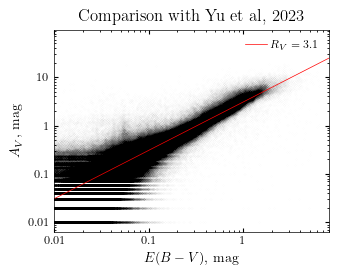

In [35]:
pl.loglog(ebv_mine,av,'k.',ms=0.1,alpha=0.1,rasterized=True)
pl.xlabel('$E(B-V)$, mag')
pl.ylabel('$A_V$, mag')
pl.plot([0.01,20],[0.01*3.1,20*3.1],'r-',label='$R_V=3.1$')
pl.xlim(0.01,8)
pl.title('Comparison with Yu et al, 2023')
pl.legend(frameon=False)

As one can see, the agreement is actually pretty decent even if E23 maps do not use this dataset, although it is of course not obvious whether $R_V=3.1$ or something close to that from this figure. Now let's do the same also for [Dékány et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...883...58D/abstract). Here table can be queried directly from Vizier, but uncertainties are not included in the main table available to querying, so for those I use fits table directly downloaded from Vizier. Also, the reddening here is estimated using either K/H bands, so some conversions need to be done if the reddening is to be compared with $A_V$ (see i.e. discussion and estimates in [Nishiyama et al 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...680.1174N/abstract)). Finally, [Dékány et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...883...58D/abstract) provide two distance estimates based on H/K band analysis, and distance estimate is needed to estimate uncertainty given by 3D maps, so I take mean of those for simplicity:

In [36]:
cpv = Vizier(columns=['all'])
cpv.ROW_LIMIT=-1
cepheids = cpv.get_catalogs('J/ApJ/883/58/cepheids')
ra_cep,de_cep,d_jk,d_hk,a_jk,a_hk,de_jk,de_hk,sde_jk,sde_hk = [cepheids[0][x].data.data for x in ['RA_ICRS','DE_ICRS','d_JK_','d_HK_','AK_JK_','AK_HK_','e_d_JK_','e_d_HK_','s_d_JK_','s_d_HK_']]
cep_pos = c.SkyCoord(ra_cep,de_cep,unit=(u.hourangle, u.deg)).transform_to(c.Galactic)

d_cep = np.nanmean((d_jk,d_hk),0)*1000
de_cep = np.nanmax([np.sqrt(de_jk**2+sde_jk**2)*1000,np.sqrt(de_hk**2+sde_hk**2)*1000,abs(d_jk-d_hk)*1000],0)

ak_cep = np.nanmean((a_jk,a_hk),0) # mean between Ak derived from J/H
ee = [fits.getdata('../J_ApJ_883_58_table8.dat.fits').field(x) for x in ['e_AK(JK)','s_AK(JK)','e_AK(HK)','s_AK(HK)']]
ake_cep = np.sqrt(sum([x**2 for x in ee],0))
ake_cep[ake_cep==0]=max(ake_cep)
m_cep = np.where(np.logical_not(np.isnan(d_cep*ak_cep)))
cep_pos = cep_pos[m_cep]
d_cep = d_cep[m_cep]
de_cep = de_cep[m_cep]
ak_cep = ak_cep[m_cep]
ake_cep = ake_cep[m_cep]
cep_pix = hp.ang2pix(256,cep_pos.l.deg,cep_pos.b.deg,lonlat=True)

ebv_cep = maps_mean[np.minimum(dbins.searchsorted(d_cep),dbins.shape[0]-1),cep_pix]

/var/folders/l9/yhh7ptgx6dqb97khkd08bkmw0000gn/T/ipykernel_88715/1068853758.py:7: RuntimeWarning: Mean of empty slice
  d_cep = np.nanmean((d_jk,d_hk),0)*1000
/var/folders/l9/yhh7ptgx6dqb97khkd08bkmw0000gn/T/ipykernel_88715/1068853758.py:8: RuntimeWarning: All-NaN axis encountered
  de_cep = np.nanmax([np.sqrt(de_jk**2+sde_jk**2)*1000,np.sqrt(de_hk**2+sde_hk**2)*1000,abs(d_jk-d_hk)*1000],0)
/var/folders/l9/yhh7ptgx6dqb97khkd08bkmw0000gn/T/ipykernel_88715/1068853758.py:10: RuntimeWarning: Mean of empty slice
  ak_cep = np.nanmean((a_jk,a_hk),0) # mean between Ak derived from J/H


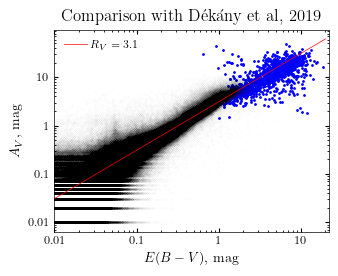

In [37]:
# for conversion between Av and Ks one can adopt 0.062 (Aks=0.062Av) from 
# https://iopscience.iop.org/article/10.1086/587791/pdf
# or 0.118 from CCM see in particular Table 1, so here multiply by this factor for quick comparison

ks2av = 1/0.118 # that's just literature value for illustration, we'll obtain updated value further on

pl.loglog(ebv_cep,ak_cep*ks2av,'b.',ms=2,rasterized=True)
pl.xlabel('$E(B-V)$, mag')
pl.ylabel('$A_K$, mag')

# plot also Yu et al data
pl.loglog(ebv_mine,av,'k.',ms=0.1,alpha=0.1,rasterized=True)
pl.xlabel('$E(B-V)$, mag')
pl.ylabel('$A_V$, mag')
pl.plot([0.01,20],[0.01*3.1,20*3.1],'r-',label='$R_V=3.1$')
pl.xlim(0.01,22)

pl.title('Comparison with Dékány et al, 2019')
pl.legend(frameon=False)

There are some obvious outliers for cepheides, so filter those out

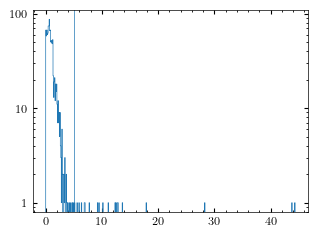

In [38]:
junk = pl.hist(abs(ak_cep*ks2av-3.1*ebv_cep)/ebv_cep,512,histtype='step')
pl.axvline(5)
pl.semilogy()
m_cep = np.where(abs(ak_cep*ks2av-3.1*ebv_cep)/ebv_cep<3)

1147
1.565588


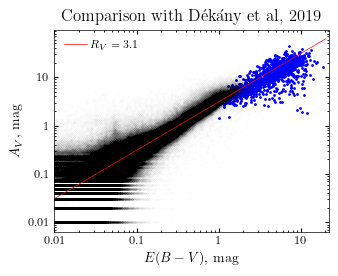

In [39]:
pl.loglog(ebv_cep[m_cep],ak_cep[m_cep]*ks2av,'b.',ms=2,rasterized=True)
pl.xlabel('$E(B-V)$, mag')
pl.ylabel('$A_K$, mag')

# plot also Yu et al data
pl.loglog(ebv_mine,av,'k.',ms=0.1,alpha=0.1,rasterized=True)
pl.xlabel('$E(B-V)$, mag')
pl.ylabel('$A_V$, mag')
pl.plot([0.01,20],[0.01*3.1,20*3.1],'r-',label='$R_V=3.1$')
pl.xlim(0.01,22)

pl.title('Comparison with Dékány et al, 2019')
pl.legend(frameon=False)
print(len(ebv_cep[m_cep]))
print(len(av)/1e6)


To answer the question whether agreement is actually good one shall in principle fit the correlation directly taking into the account uncertainties. This needs to be done separately for $V$ and $K_S$ bands, of course (which allows also to calibrate relation in reddening for two bands). Basic idea is thus to perform MLE fitting to get $R_X$ value, its uncertainty, and estimate quantitatively estimate the goodness of fit and residual scatter, i.e. uncertainty for our combined map. Let us do a joint fit (which allows to get direct coversion between $A_V$ and $A_K$). Here I use *ultranest* package to take into the account reported extintion/reddening and estimate additive and relative uncertainties for the fused maps obtained here. As a first step, we need to simulate some $A_V$ distributions (taking into the account reported uncertainties)

In [40]:
# simulated value of reddening in our maps taking into the account uncertainties in distance for stars in Yu et al sample
nsim = 100
ebv_sim = np.array([maps_mean[np.minimum(dbins.searchsorted(np.random.normal(loc=d,scale=de)),dbins.shape[0]-1),pix] for i in range(nsim)])
# and their reported uncertainties
av_sim = np.array([np.random.normal(loc=av,scale=ave) for i in range(nsim)])
samples_av = np.swapaxes(np.swapaxes(np.array([ebv_sim,av_sim]),0,2),1,2)

And same for [Dékány et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...883...58D/abstract) cepheides:

In [41]:
ebv_cep_sim = np.array([maps_mean[np.minimum(dbins.searchsorted(np.random.normal(loc=d_cep[m_cep],scale=de_cep[m_cep])),dbins.shape[0]-1),cep_pix[m_cep]] for i in range(nsim)])
ak_cep_sim = np.array([np.random.normal(loc=ak_cep[m_cep],scale=ake_cep[m_cep]) for i in range(nsim)])
samples_ak = np.swapaxes(np.swapaxes(np.array([ebv_cep_sim,ak_cep_sim]),0,2),1,2)

Now repeat similar fit with *ultranest* as above to calibrate our map to actually match arguably more reliable spectro-photometric $A_V$ estimates by Yu et al 23 for fixed assumed $R_V=3.1$ (to match commonly used value), and estimate ratio of $R_V/R_K$, which is also of interest (and gives a clue on whether our results are any good, actually!). Finally, this step allows also to estimate actual uncertainty of our map not only at infintiy but everywhere (and using  more appropriate dataset). The difference in likelihoods here is that they take uncertainty estimates from both papers.

In [42]:
parameters = ['add_err', 'rel_err','Rv','Rv2Rk'] #Rv2Rk to compare w. Table 1 in https://iopscience.iop.org/article/10.1086/587791/pdf

p0 = np.array([0.05054956, 0.28890373, 3.11061072, 0.10331459])
#
def prior_transform(cube):
    params = cube.copy()
    lo = 0
    hi = 0.5
    params[0] = cube[0] * (hi - lo) + lo
    lo = 0
    hi = 0.5
    params[1] = cube[1] * (hi - lo) + lo
    lo = 3.0
    hi = 3.6
    params[2] = cube[2] * (hi - lo) + lo
    lo = 0.05
    hi = 0.2
    params[3] = cube[3] * (hi - lo) + lo
    return params

def log_likelihood(params):
    # unpack the current parameters:
    # slope, offset, scatter = params
    add_err, rel_err, Rv, Rv2Rk = params
    av_expected = (samples_av[:,0]) * Rv
    probs_av = scipy.stats.norm(av_expected,np.sqrt((rel_err*av_expected)**2+add_err**2)).pdf(samples_av[:,1])
    probs_oav = probs_av.mean(axis=1)
    ak_expected = (samples_ak[:,0]) * Rv * Rv2Rk
    probs_ak = scipy.stats.norm(ak_expected,np.sqrt((rel_err*ak_expected)**2+add_err**2)).pdf(samples_ak[:,1])
    probs_oak = probs_ak.mean(axis=1)
    # need to correct for number of simulated points, could take mean over each cloud as well, but easier to do it directly
    loglike = np.log(probs_oav + 1e-100).sum()/nsim + np.log(probs_oak+1e-100).sum()/nsim
    return loglike

In [43]:
sampler_fusedXYK23DH19 = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)

In [44]:
# result_fusedXYK23DH19 = sampler_fusedXYK23DH19.run()
# pickle.dump(result_fusedXYK23DH19,open('ultranest_result_fusedXYK23DH19.pkl','wb'))
result_fusedXYK23DH19 = pickle.load(open('ultranest_result_fusedXYK23DH19.pkl','rb'))

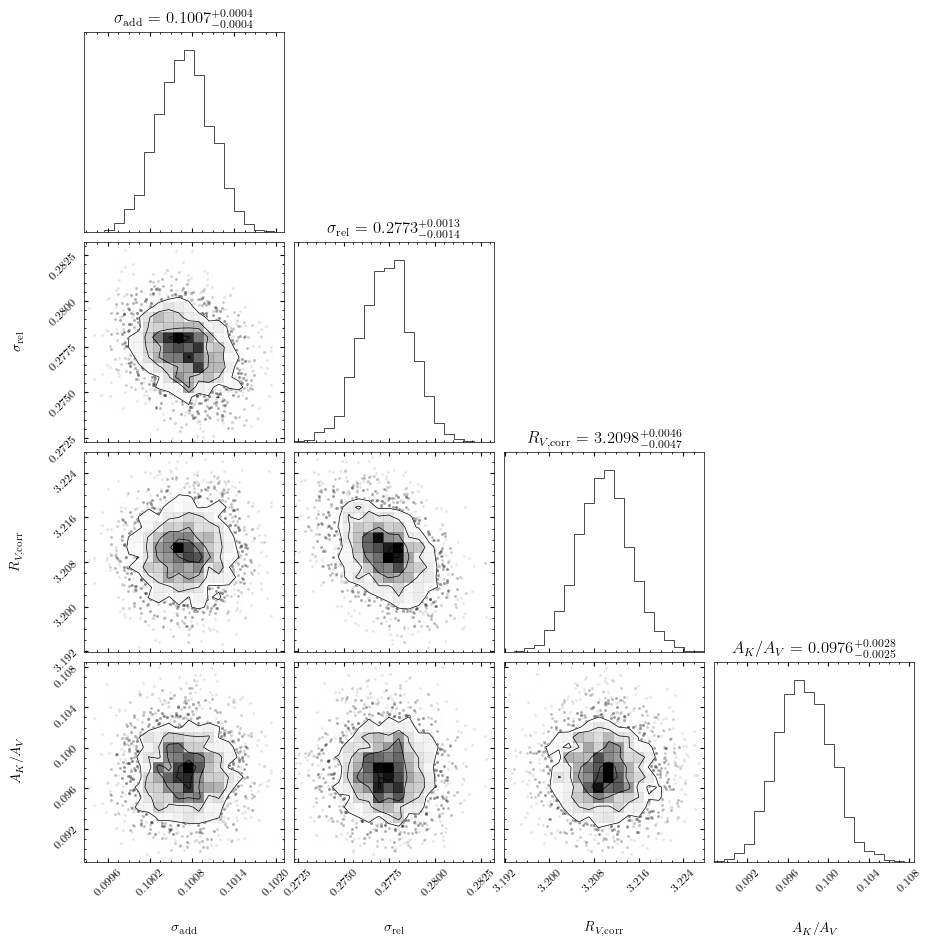

In [45]:
junk = corner.corner(result_fusedXYK23DH19['samples'],show_titles=True,labels=[r'$\sigma_{\rm add}$',r'$\sigma_{\rm rel}$',r'$R_{V, \rm{corr}}$', r'$A_K/A_V$'],title_fmt='.4f')
pl.savefig('corner_yk23dh19.pdf')

The fact that $R_V$ differs from 3.1 implies that conversion of E23 monochromatic extintion to reddening using the ratio 2.8/3.1 done above is a bit off if one wants to scale that to standard extinction law (both optical papers), so we need to re-scale our maps. Before doing so lets check the scaling:

In [46]:
np.mean(samples_ak,-1)[:,0]

array([2.88144531, 2.34710938, 2.51734375, ..., 2.70832031, 2.11083984,
       2.54101562])

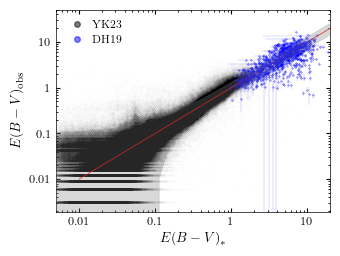

In [47]:
add_err, rel_err, Rv, Rv2Rk = result_fusedXYK23DH19['posterior']['mean']
# Rv2Rk=0.09
pl.plot(ebv_mine,av/Rv,'k.',ms=0.1,rasterized=True,alpha=0.1)
# pl.errorbar(ebv_cep,ak_cep/(Rv*Rv2Rk),ake_cep/(Rv*Rv2Rk),fmt='b.',ms=0.5,alpha=1,rasterized=False,lw=0.1)
pl.errorbar(np.mean(samples_ak,-1)[:,0],np.mean(samples_ak,-1)[:,1]/(Rv*Rv2Rk),np.std(samples_ak,-1)[:,1]/(Rv*Rv2Rk),np.std(samples_ak,-1)[:,0],'b.',ms=0.5,alpha=1,rasterized=False,lw=0.1)
pl.plot([np.nan],[np.nan],'k.',ms=8,rasterized=True,alpha=0.5,label=r'YK23') # otherwise labels are not visible
pl.plot([np.nan],[np.nan],'b.',ms=8,alpha=0.5,rasterized=False,label=r'DH19') # # otherwise labels are not visible
pl.loglog()
pl.plot([0.01,20],[0.01,20],'r-')

from ultranest.plot import PredictionBand
x = np.logspace(-4,np.log10(25),100)
bandav = PredictionBand(x)


for params in result_fusedXYK23DH19['samples']:
    add_err, rel_err, Rv, Rv2Rk = params
    # slope = 2.8/3.1
    y_expected = Rv*x/result_fusedXYK23DH19['posterior']['mean'][2]
    y = scipy.stats.norm(y_expected, np.sqrt(add_err**2+(y_expected*rel_err)**2)).rvs()
    bandav.add(y)
    
    # indicate intrinsic scatter
    # band_hi.add(y + scatter)
    # band_lo.add(y - scatter)



bandav.shade(color='gray', alpha=0.3,zorder=5)
# bandav.line(color='k')
# bandak.shade(color='blue', alpha=0.3,zorder=5)
# bandak.line(color='k')


pl.legend(frameon=False,loc=2)
pl.xlim(0.005,20)
pl.xlabel('$E(B-V)_*$')
pl.ylabel(r'$E(B-V)_{\rm obs}$')
pl.loglog()
pl.savefig('verification_dh19_yj23.pdf')

Now the curves are aligned, and we have an independent estimate of ration of $R_V$ to $R_K$. We also can correct our fused map such that its $E(B-V)$ matches canonical $R_V=3.1$ (assuming $A_V$ reported in YK23 are correct), and save this final reddening map to npz. Record also best-fit $R_V/R_K$ ratio for future use

In [48]:
np.savez_compressed('e23_x_ymw16_cor31.npz',maps = (3.1/Rv*final_cube).astype(np.float16), radius=rymw16,Rv2Rk=Rv2Rk, add_err=add_err, rel_err=rel_err)

We can also do some extra diagnostic plots to see how calibration worked out (re-read map, repeat steps above):

In [49]:
maps_mean = np.load('e23_x_ymw16_cor31.npz')['maps']
dbins = np.load('e23_x_ymw16_cor31.npz')['radius']

ebv_cep = maps_mean[np.minimum(dbins.searchsorted(d_cep),dbins.shape[0]-1),cep_pix]
ebv_mine = maps_mean[np.minimum(dbins.searchsorted(d),dbins.shape[0]-1),pix]

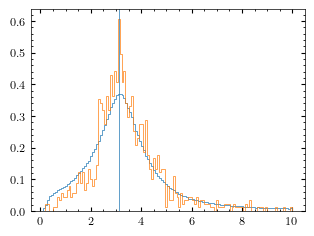

In [50]:
junk = pl.hist(av/ebv_mine,np.linspace(0.1,10,128),histtype='step',density=True)
junk = pl.hist(ak_cep/ebv_cep/Rv2Rk,np.linspace(0.1,10,128),histtype='step',density=True)
pl.axvline(3.1)

That is, the $E(B-V)$ values in our map are now indeed scaled to $R_V=3.1$ (to reproduce extintion in $V$ and $K_S$ bands for majority of stars in [Yu et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJS..264...41Y/abstract) and [Dékány et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...883...58D/abstract) catalogues. The important point here is that this statement applies now not only to inner 2\,kpc already covered by E23 maps, but also beyond. 

We can visualize stars using for verification overlayed with the Galaxy along with approximated YMW16 density. To do that we need to calculate both the cumulative reddening and local YMW16 density on some grid:

In [51]:
import pygedm # interface to YMW models

x,y,z = np.linspace(-40,40,512)*1000,np.linspace(-40,40,512)*1000,np.linspace(-400,400,10)
X,Y,Z = np.meshgrid(x,y,z)

pos3d = c.SkyCoord(X*u.pc,Y*u.pc,Z*u.pc,frame='galactocentric')
posg = pos3d.transform_to(c.Galactic)
ipix = hp.ang2pix(256,posg.l.deg,posg.b.deg,lonlat=True)
dpix = dbins.searchsorted(posg.distance.pc)
mm = np.where(dpix<len(dbins))
ipix,dpix = ipix[mm],dpix[mm]
xm,ym,zm = X[mm],Y[mm],Z[mm]
ymw2d = np.vectorize(lambda x,y,z: pygedm.calculate_electron_density_xyz(x,y,0).value)(X,Y,Z)

And cumulative reddening from our maps based on grid positions

In [52]:
ebv = maps_mean[dpix,ipix] # that's just for illustration, so use unrescaled maps

Now we can plot locations of our stars. Here the main issue is that there are too many stars in YJ dataset which are too clustered towards the Sun to make a nice plot from visual perspective if we consider entire Galaxy (they'd just form a black circle with ~2kpc in size, the sheer number is sufficient to produce something like E23 in the end in this area!). We can slim those down giving more weight to those located further away (complex procedure) to show that there are also a lot of objects located beyond region covered by E23 map. Note that all objecta are actually used for calibration, the slimming is only done for plotting here. 

In [53]:
m = np.where(d<=25000) # to filter out points outside range covered by map
teff,d,de,av,ave,l,b = [x[m] for x in (teff,d,de,av,ave,l,b)]
avpos = c.SkyCoord(l*u.deg,b*u.deg,distance=d*u.pc,frame='galactic')
avx,avy,avz = avpos.transform_to(c.Galactocentric).x.to(u.kpc).value, avpos.transform_to(c.Galactocentric).y.to(u.kpc).value,avpos.transform_to(c.Galactocentric).z.to(u.kpc).value
avdbins = [0]+list(1000*np.logspace(-1,np.log10(20),32)[8:])
avdbins = avdbins[:-4]+[30000]

avxx,avyy = [],[]
for i in range(len(avdbins)-1):
    mav = np.where((np.abs(avz)<0.4)*(d>=avdbins[i])*(d<=avdbins[i+1]))[0]
    mav_slim = np.random.choice(mav,min(len(mav),int(1e6/len(mav))+200))
    avxx.append(avx[mav_slim])
    avyy.append(avy[mav_slim])


Note, that no such slimming is required for cepheids which are not so many and are all qute far away. I do, however, still only plot subset of those which are within 400 pc from the Galactic plane to match volume used for colormaps (cumulative and differential)

In [54]:
cep_pos3d = c.SkyCoord(cep_pos.l,cep_pos.b,distance=d_cep*u.pc,frame="galactic").transform_to(c.Galactocentric)
cmask = np.where(np.logical_not(np.isnan(d_cep))*(np.abs(cep_pos3d.z.value)<=400))

Read also positions of X-ray sources:zhu = open('zhu_table.dat','r').readlines()[1:]
lzhu = [float(x.split('&')[1].strip()) for x in zhu if x.find('#')!=0]
bzhu = [float(x.split('&')[2].strip()) for x in zhu if x.find('#')!=0]
dzhu = [len(x.split('&')[8].strip())==0 and np.nan or float(x.split('&')[8].strip()) for x in zhu if x.find('#')!=0]
zhupos = c.SkyCoord(lzhu*u.deg,bzhu*u.deg,distance=dzhu*u.kpc,frame='galactic')


In [55]:
zhu = open('zhu_table.dat','r').readlines()[1:]
lzhu = [float(x.split('&')[1].strip()) for x in zhu if x.find('#')!=0]
bzhu = [float(x.split('&')[2].strip()) for x in zhu if x.find('#')!=0]
dzhu = [len(x.split('&')[8].strip())==0 and np.nan or float(x.split('&')[8].strip()) for x in zhu if x.find('#')!=0]
zhupos = c.SkyCoord(lzhu*u.deg,bzhu*u.deg,distance=dzhu*u.kpc,frame='galactic')
zhupos3d = zhupos.transform_to(c.Galactocentric)

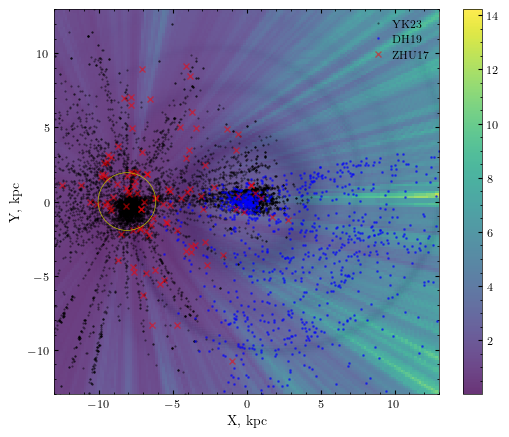

In [56]:
fig = pl.figure(figsize=(6.2,5))
pl.pcolormesh(x/1000,y/1000,np.mean(ymw2d,-1)[::-1].T,cmap=pl.cm.binary,rasterized=True,vmin=0,vmax=1)
pl.pcolormesh(x/1000,y/1000,scipy.stats.binned_statistic_2d(xm,ym,ebv,bins=(x,y))[0].T,alpha=0.8,rasterized=True)
# pl.axis('equal')
pl.xlim(-13,13)
pl.ylim(-13,13)
pl.plot(np.concatenate(avxx),np.concatenate(avyy),'k.',ms=1,alpha=0.5,rasterized=True,label='YK23')
pl.plot(cep_pos3d.x.value[cmask]/1000, cep_pos3d.y.value[cmask]/1000,'b.',ms=2,alpha=0.5,rasterized=True,label='DH19')
pl.plot(zhupos3d.x.value, zhupos3d.y.value,'rx',ms=5,alpha=0.5,rasterized=True,label='ZHU17')
pl.gca().add_patch(matplotlib.patches.Circle((-8.1,0),1.95,facecolor='none',ec='y',zorder=5))
pl.legend(frameon=False)
pl.xlabel('X, kpc')
pl.ylabel('Y, kpc')
# pl.axis('equal')
pl.colorbar()
pl.savefig('galmap.pdf')

## Calibration of the X-ray absorbtion column
Finally, let us calibrate the relation between our fused $E(B-V)$ map and X-ray absorbtion column. There's really not a whole lot of data on 3D absorbtion, but still, there are some estimates. In particular, there is some information regarding extinction and X-ray absorbtion towards SNRs and XRBs which was in the past used in the literature for such studies. Recent examples are [Güver et al, 2009](https://ui.adsabs.harvard.edu/abs/2009MNRAS.400.2050G/abstract), a follow-up of this work by [Foight et al 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...826...66F/abstract) who analyze extintion and X-ray absorbtion based on analysis using Supernova-remnant (SNR) observations, and most recently [Zhu et al 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.3494Z/abstract) where in addition to SNR observations also X-ray binary (XRB) and planetary nebulae (PNe) observations were used. 

The range of the conversion factors between $A_V$ and $N_H$ reported in the literature ranges from $\sim 1.8-3.3\times10^{21}A_V$ and depends on objects considered/sample size, way the $A_V$ and $N_H$ are measured, assumed ISM abundances and so on. For full (mixed) set of objects [Zhu et al 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.3494Z/abstract) finds, e.g. $2.08(2)\times10^{21}$cm$^{-1}$ and $2.47(4)\times10^{21}$cm$^{-1}$ for solar ([Anders&Grevesse 89 = AG89](https://ui.adsabs.harvard.edu/abs/1989GeCoA..53..197A/abstract)) and sub-solar ([Wilms et al 2000 = W00](https://ui.adsabs.harvard.edu/abs/2000ApJ...542..914W/abstract)) abundances. To my knowledge [Zhu et al 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.3494Z/abstract) is the most recent work relying on the largest sample of various objects with reasonably reliable (albeit heterogenous) $N_H$, $A_V$ and, crucially, distance estimates, so I use this database here for calibration (basically substituting literature $A_V$ estimates with $E(B-V)$ obtained from 3D maps presented above). To do so, I copied the content of their Table 4 to separate file (from arxiv latex source), and parse that to get the requiered values. The $E(B-V)$ values are queried directly from our mean maps (corrected to match YK23 $A_V$ values for standard extintion law):

In [57]:
zhu_av = [float(x.split('&')[7].strip().split('$')[0]) for x in zhu if x.find('#')!=0]
zhu_ave = [float(x.split('&')[7].strip().split('$')[-1]) for x in zhu if x.find('#')!=0]
zhu_nh = [float(x.split('&')[5].strip().split('$')[0]) for x in zhu if x.find('#')!=0]
zhu_nhe = [float(x.split('&')[5].strip().split('$')[-1]) for x in zhu if x.find('#')!=0]
zhu_nhw = [len(x.split('&')[6].strip())==0 and np.nan or float(x.split('&')[6].strip().split('$')[0]) for x in zhu if x.find('#')!=0]
zhu_nhwe = [len(x.split('&')[6].strip())==0 and np.nan or float(x.split('&')[6].strip().split('$')[-1]) for x in zhu if x.find('#')!=0]
mnnan = np.where(np.logical_not(np.isnan(dzhu)))
lzhu,bzhu,dzhu,zhu_av,zhu_ave,zhu_nh,zhu_nhe,zhu_nhw,zhu_nhwe = [np.array(x)[mnnan] for x in (lzhu,bzhu,dzhu,zhu_av,zhu_ave,zhu_nh,zhu_nhe,zhu_nhw,zhu_nhwe)]

zhupix = hp.ang2pix(256,lzhu,bzhu,lonlat=True)
zhudpix = dbins.searchsorted(dzhu*1000)
ebv_zhu = maps_mean[zhudpix,zhupix]
ebve_zhu = np.sqrt(add_err**2+(ebv_zhu*rel_err)**2)

In [58]:
print(len(lzhu))

103


as a first step we can do a visual comparison of values reported by Zhu et al with our results :

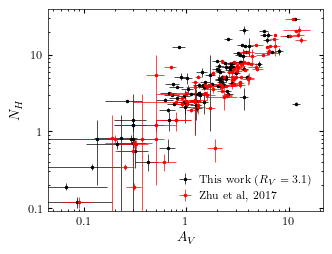

In [59]:
pl.errorbar(ebv_zhu*3.1,zhu_nh,zhu_nhe,ebve_zhu,fmt='k.',ms=3,label='This work ($R_V=3.1$)')
pl.errorbar(zhu_av,zhu_nh,zhu_nhe,zhu_ave,fmt='r.',ms=3,label='Zhu et al, 2017')
# pl.errorbar(zhu_av,zhu_nhw,zhu_nhwe,zhu_ave,fmt='b.',ms=3,label='Zhu et al, 2017')
pl.xlabel('$A_V$')
pl.ylabel('$N_H$')
pl.legend(frameon=False)
pl.loglog()
pl.savefig('zhuvsours.pdf')

As one can see, agreement is decent, altough our values appear to be systematically higher and with somewhat more scatter (even if some points are on the contrary more aligned with overall correlation). Let us fit our data using the same method as above to get the slope of the dependence (for full Zhu et al 17 set with AG89 abundances which contains more objects):

In [60]:
samples_zhu = np.transpose([(np.random.normal(loc=ebv_zhu,scale=ebve_zhu), np.random.normal(loc=zhu_nh,scale=zhu_nhe)) for i in range(nsim)])

parameters = ['Av2nH', 'add_err21', 'rel_err21']

def prior_transform_zhu_ebv(cube):
    params = cube.copy() # slope add_err, rel_err
    params[0] = cube[0] * (20 - 0.01) + 0.01
    params[1] = cube[1] * (10 - 0.0) + 0.0 # assume maximum 1e22 additive error
    params[2] = cube[2] * (10 - 0.00) + 0.0 # assume 0-150% error
    return params

def log_likelihood_zhu_ebv(params):
    # unpack the current parameters:
    # slope, offset, scatter = params
    slope, add_err, rel_err = params
    nh_expected = (samples_zhu[:,0]) * slope
    probs = scipy.stats.norm(nh_expected,np.sqrt((rel_err*nh_expected)**2+add_err**2)).pdf(samples_zhu[:,1])
    loglike = np.log(probs + 1e-100).sum()/nsim
    return loglike


sampler_zhu_ebv = ultranest.ReactiveNestedSampler(parameters, log_likelihood_zhu_ebv, prior_transform_zhu_ebv)
result_zhu_ebv = sampler_zhu_ebv.run(min_num_live_points=2000)

[ultranest] Sampling 2000 live points from prior ...


[ultranest] Explored until L=-3e+02  .42 [-268.4789..-268.4789]*| it/evals=28567/47183 eff=63.2251% N=2000 
[ultranest] Likelihood function evaluations: 47209
[ultranest]   logZ = -278.1 +- 0.04631
[ultranest] Effective samples strategy satisfied (ESS = 9688.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)
[ultranest]   logZ error budget: single: 0.06 bs:0.05 tail:0.01 total:0.05 required:<0.50
[ultranest] done iterating.


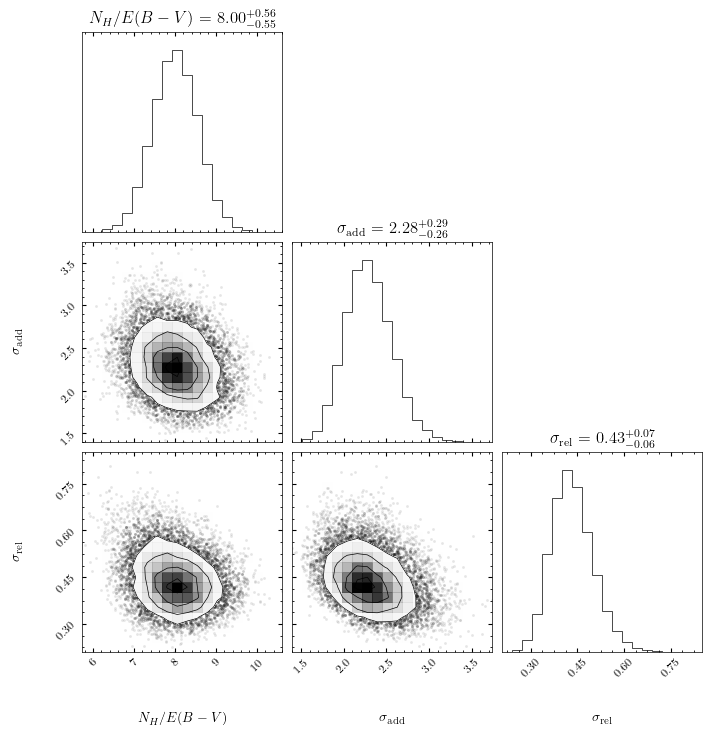

In [61]:
junk = corner.corner(result_zhu_ebv['samples'],show_titles=True,labels=[r'$N_H/E(B-V)$',r'$\sigma_{\rm add}$',r'$\sigma_{\rm rel}$'])
pl.savefig('corner_ebv_zhu_ag89.pdf')

Or, in terms of $A_V$. Here $R_V$=3.1 is assumed:  

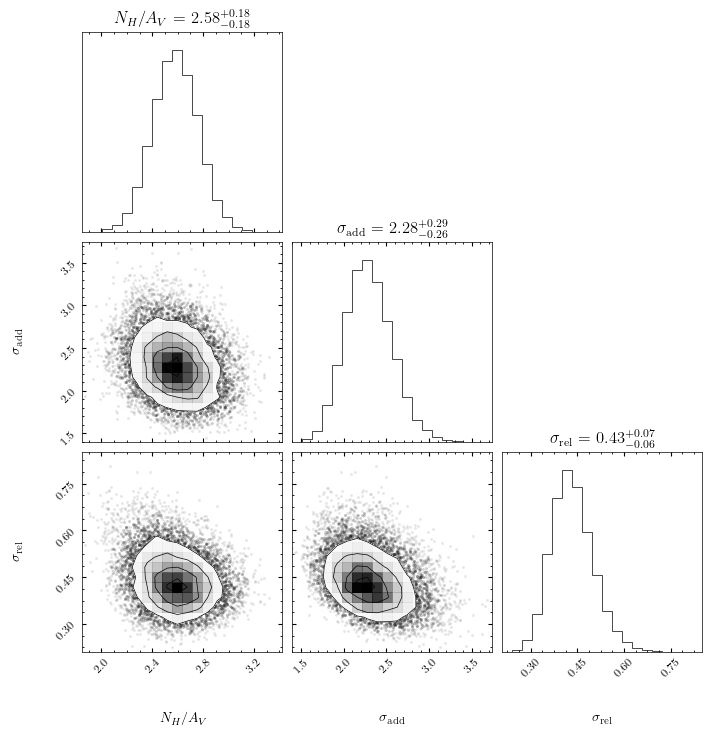

In [62]:
junk = corner.corner(np.transpose([result_zhu_ebv['samples'][:,0]/3.1,result_zhu_ebv['samples'][:,1],result_zhu_ebv['samples'][:,2]]),show_titles=True,labels=[r'$N_H/A_V$',r'$\sigma_{\rm add}$',r'$\sigma_{\rm rel}$'])
pl.savefig('corner_av_uncor_zhu_ag89.pdf')

As one can see, value is somewhat larger than that reported by Zhu, although the difference is not really significant if one considers scatter of individual points. We can also re-plot the fit now in terms of $E(B-V)$ showing also the confidence range for obtained $N_H$ (for full sample of Zhu et al, i.e. AG89 abundances which contain more objects):

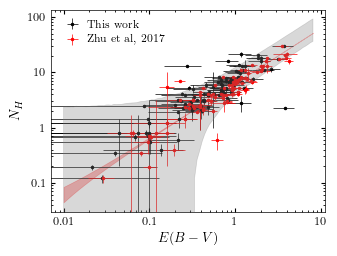

In [63]:
pl.errorbar(ebv_zhu,zhu_nh,zhu_nhe,ebve_zhu,fmt='k.',ms=3,label='This work')
pl.errorbar(zhu_av/3.1,zhu_nh,zhu_nhe,zhu_ave/3.1,fmt='r.',ms=3,label='Zhu et al, 2017')
pl.xlabel('$E(B-V)$')
pl.ylabel('$N_H$')
pl.legend(frameon=False, loc='upper left')
pl.loglog()


x = np.logspace(-2,np.log10(8),100)
bandnh = PredictionBand(x)


for params in result_zhu_ebv['samples']:
    slope, add_err, rel_err = params
    y_expected = slope*x
    y = scipy.stats.norm(y_expected, np.sqrt(add_err**2+(y_expected*rel_err)**2)).rvs()
    bandnh.add(y)

bandnh.shade(color='gray', alpha=0.3,zorder=5)
pl.fill_between(x,x*3.1*2.08-0.02,x*3.1*2.08+0.02,alpha=0.3,color='red')
pl.savefig('zhuvsours_band.pdf')

As one can see, we do get indeed slightly larger conversion constant value (as evident already from the offset between red/black points), although not very strong if one considers overall scatter of the points (both red and black). Note also that uncertainties reported by Zhu et al 2017 are likely underestimated as they are derived from simple $\chi^2$ fitting using *MPFIT* without considering goodness of fit (i.e. scatter of red points is clearly larger than the shaded red band implied by their reported uncertainties). That said, the systematic shift is still there and reason for this discrepancy is not fully clear. I suspect, however, that the reason is that I calibrate reddening maps to E23 $A_0$ measurements (adjusted to match $A_V$ by YK23) rather than the other way around as usually done (i.e. most $A_V$ estimates reported in Zhu et al are, in fact, reddening estimates converted to $A_V$ and calibrated to Schlegel maps which, we assume, over-estimate true reddening). Remember, i.e. the $R_{\rm corr}\sim0.8$ coefficient implying that Schlegel/GNILC maps need to be multiplied by 0.8 to get E23 $A_V$ values which we used in the beginning to normalize the GNILC maps to E23. We can revert this correction, for comparison with Zhu (calibrated to Shlegel for most cases), which produces results similar to Zhu et al:

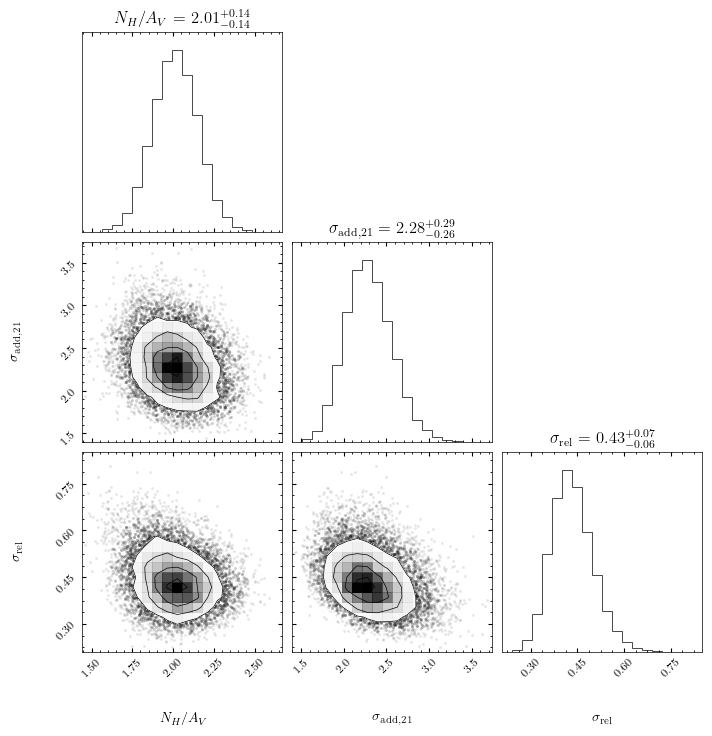

In [64]:
junk = corner.corner(np.transpose([result_zhu_ebv['samples'][:,0]/3.1*Rv_correction,result_zhu_ebv['samples'][:,1],result_zhu_ebv['samples'][:,2]]),show_titles=True,labels=[r'$N_H/A_V$',r'$\sigma_{\rm add,21}$',r'$\sigma_{\rm rel}$'])
pl.savefig('corner_av_cor_zhu_ag89.pdf')

The same can be done for sub-sample of $N_H$ measurements assuming Wilms abundances (from Zhu et al):

In [65]:
mwnan = np.where(np.logical_not(np.isnan(zhu_nhw)))

samples_zhuw = np.transpose([(np.random.normal(loc=ebv_zhu[mwnan],scale=ebve_zhu[mwnan]), np.random.normal(loc=zhu_nhw[mwnan],scale=zhu_nhe[mwnan])) for i in range(nsim)])

parameters = ['Av2nH', 'add_err21', 'rel_err21']

def prior_transform_zhuw_ebv(cube):
    params = cube.copy() # slope add_err, rel_err
    params[0] = cube[0] * (20 - 0.01) + 0.01
    params[1] = cube[1] * (10 - 0.0) + 0.0 # assume maximum 1e22 additive error
    params[2] = cube[2] * (10 - 0.00) + 0.0 # assume 0-150% error
    return params

def log_likelihood_zhuw_ebv(params):
    # unpack the current parameters:
    # slope, offset, scatter = params
    slope, add_err, rel_err = params
    nh_expected = (samples_zhuw[:,0]) * slope
    probs = scipy.stats.norm(nh_expected,np.sqrt((rel_err*nh_expected)**2+add_err**2)).pdf(samples_zhuw[:,1])
    loglike = np.log(probs + 1e-100).sum()/nsim
    return loglike


sampler_zhuw_ebv = ultranest.ReactiveNestedSampler(parameters, log_likelihood_zhuw_ebv, prior_transform_zhuw_ebv)
result_zhuw_ebv = sampler_zhuw_ebv.run(min_num_live_points=2000)


[ultranest] Sampling 2000 live points from prior ...


[ultranest] Explored until L=-1e+02  .32 [-110.3789..-110.3789]*| it/evals=25479/42176 eff=63.4185% N=2000 
[ultranest] Likelihood function evaluations: 42238
[ultranest]   logZ = -118.5 +- 0.04308
[ultranest] Effective samples strategy satisfied (ESS = 10033.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)
[ultranest]   logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50
[ultranest] done iterating.


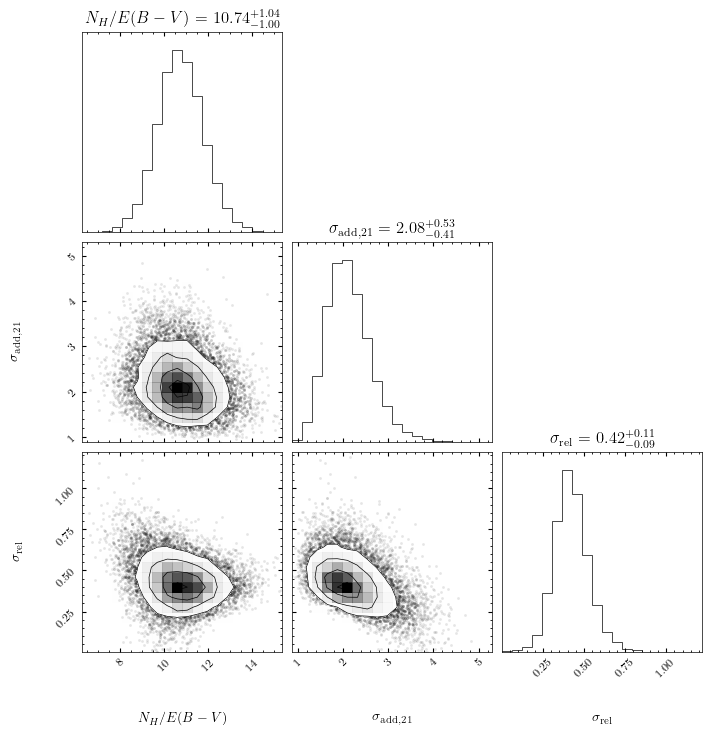

In [66]:
junk = corner.corner(result_zhuw_ebv['samples'],show_titles=True,labels=[r'$N_H/E(B-V)$',r'$\sigma_{\rm add,21}$',r'$\sigma_{\rm rel}$'])
pl.savefig('corner_ebv_zhu_w00.pdf')

Again, to match Zhu et al 2017 results we need to revert $R_V$ correction, which agains yields results similar to Zhu et al 2017:

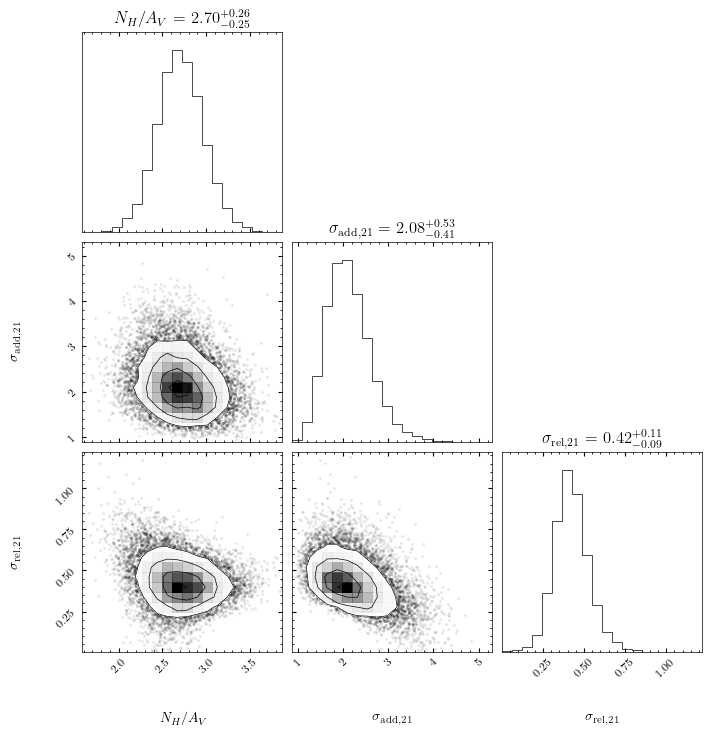

In [67]:
junk = corner.corner(np.transpose([result_zhuw_ebv['samples'][:,0]/3.1*Rv_correction,result_zhuw_ebv['samples'][:,1],result_zhuw_ebv['samples'][:,2]]),show_titles=True,labels=[r'$N_H/A_V$',r'$\sigma_{\rm add,21}$',r'$\sigma_{\rm rel,21}$'])
pl.savefig('corner_avcor_zhu_w00.pdf')

Note that from practical perspective to use the obtained calibrated 3D maps we have to use $E(B-V)/N_H$ coversion factor directly, i.e. stick to defined $A_V$ calibration point for our maps (which is YJ23 for us). The motivation for this choice is that YJ23 results combine  several tracers (astro-seismology, spectroscopy, photometry), state of the art stellar atmosphere models, and largest sample of objects to date. They also produce results consistent with E23 (base map for 3D part of our maps), and thus are ideal for our study. One needs to bear in mind, however, when doing direct comparisons with reddening/extintion reported in the older literature, that those might slighly deviate from what's reported here due to the different choice of calibration (i.e. Schlegel reddening vs YJ23 extinction). Now we can save final file with all relevant conversion factors:

In [68]:
np.savez_compressed('ebv_fin.npz',maps = maps_mean, radius=rymw16,
                    Rv=3.1,
                    calib_avks_mean=result_fusedXYK23DH19['posterior']['mean'],
                    calib_avks_std=result_fusedXYK23DH19['posterior']['stdev'], 
                    calib_nhag89_mean=result_zhu_ebv['posterior']['mean'],
                    calib_nhag89_std=result_zhu_ebv['posterior']['stdev'],
                    calib_nhw00_mean=result_zhuw_ebv['posterior']['mean'],
                    calib_nhw00_std=result_zhuw_ebv['posterior']['stdev'])